In [39]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression, BayesianRidge
import statsmodels.api as sm

import torch
import gpytorch

data_dir = '../../data/'

### Load the data

In [40]:
# Read the data and parse the PROF_DATE_TIME_LOCAL column to a datetime object
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])

# convert the data column to a value that can be used for machine learning
data['PROF_DATE_TIME_LOCAL'] = pd.to_datetime(data['PROF_DATE_TIME_LOCAL'], utc=True)
data['YEAR'] = data['PROF_DATE_TIME_LOCAL'].dt.year
data['MONTH'] = data['PROF_DATE_TIME_LOCAL'].dt.month
data['DAY'] = data['PROF_DATE_TIME_LOCAL'].dt.day

sal_temp_ph = data[
  (data['SAL (PSU)'].notnull())
  & (data['pH ()'].notnull())
  & (data['TEMP (C)'].notnull())
  & (data['PROF_DATE_TIME_LOCAL'].notnull())
  & (data['DEPTH (m)'].notnull())
  & (data['LATITUDE'].notnull())
  & (data['LONGITUDE'].notnull())
  ]

# Station N18 will be used for validation
station = 'N18'
n18 = sal_temp_ph[sal_temp_ph['STAT_ID'] == station]
sal_temp_ph = sal_temp_ph[sal_temp_ph['STAT_ID'] != station]

len(sal_temp_ph)

3013

### Gaussian Process Regression

In [41]:
SAL = sal_temp_ph['SAL (PSU)'].values.reshape(-1, 1)
TEMP = sal_temp_ph['TEMP (C)'].values.reshape(-1, 1)
YEAR = sal_temp_ph['YEAR'].values.reshape(-1, 1)
MONTH = sal_temp_ph['MONTH'].values.reshape(-1, 1)
DAY = sal_temp_ph['DAY'].values.reshape(-1, 1)
LAT = sal_temp_ph['LATITUDE'].values.reshape(-1, 1)
LON = sal_temp_ph['LONGITUDE'].values.reshape(-1, 1)
DEPTH = sal_temp_ph['DEPTH (m)'].values.reshape(-1, 1)
X = np.concatenate((SAL, TEMP, YEAR, MONTH, DAY, LAT, LON, DEPTH), axis=1)

Y = sal_temp_ph['pH ()'].values.reshape(-1, 1)

In [42]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(Y).float()

In [43]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [44]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# If a gpu is available, use it
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    train_x = train_x.cuda()
    train_y = train_y.cuda()

In [45]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [15]:
training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

KeyboardInterrupt: 

In [48]:
n18_test = pd.DataFrame()
x = np.arange(0, len(n18))
for column in ['SAL (PSU)', 'TEMP (C)', 'LATITUDE', 'LONGITUDE', 'DEPTH (m)']:
    y = n18[column].values
    xvals = np.linspace(0, len(n18), 1000)
    test_x = np.interp(xvals, x, y)

SAL, TEMP, YEAR, MONTH, DAY, LAT, LON, DEPTH
y = n18[['SAL (PSU)', 'TEMP (C)', 'YEAR', 'MONTH', 'DAY', 'LATITUDE', 'LONGITUDE', 'DEPTH (m)']].values
xvals = np.linspace(0, len(n18), 500)
test_x = np.interp(xvals, x, y)

ValueError: Data points must be 1-D sequences

In [ ]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.from_numpy(n18[['LATITUDE', 'LONGITUDE', 'year', 'month', 'day', 'DEPTH (m)']].values).float()
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

mean = mean.cpu()
lower = lower.cpu()
upper = upper.cpu()

train_x = train_x.cpu()
train_y = train_y.cpu()
test_x = test_x.cpu()

In [ ]:
dates = n18['PROF_DATE_TIME_LOCAL']

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 3))

    # Plot training data as black stars
    ax.plot(n18['PROF_DATE_TIME_LOCAL'], n18['pH ()'], 'ko')

    # Max date
    max_date = dates.max()
    min_date = dates.min()

    # Date for every day in the range
    #dates2 = np.arange(min_date, max_date, dtype='datetime64[D]')
    dates2 = dates.astype('datetime64[ns]')
    
    # Plot predictive means as blue line
    ax.plot(dates, observed_pred.mean.numpy(), 'b')

    # Shade between the lower and upper confidence bounds
    ax.fill_between(dates, lower.numpy(), upper.numpy(), alpha=0.5)

    # Set x axis label
    ax.set_xlabel('Date')

    # Set y axis label
    ax.set_ylabel('pH ()')

    ax.legend(['Validation Data', 'Mean', 'Confidence'])

    # Title
    ax.set_title('Validation with Station N18')

In [8]:
# Bayesian Ridge Regression
X1 = sal_and_ta_no_outliers['SAL (PSU)'].values.reshape(-1, 1)
X2 = sal_and_ta_no_outliers['TEMP (C)'].values.reshape(-1, 1)
X = np.concatenate((X1, X2), axis=1)
Y = sal_and_ta_no_outliers['pH ()'].values.reshape(-1, 1)
bayesian_regressor = BayesianRidge()
bayesian_regressor.fit(X, Y)
Y_pred = bayesian_regressor.predict(X)

/Users/becklabash/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
sal_and_ta_no_outliers['TEMP (C)'].min()

1.622

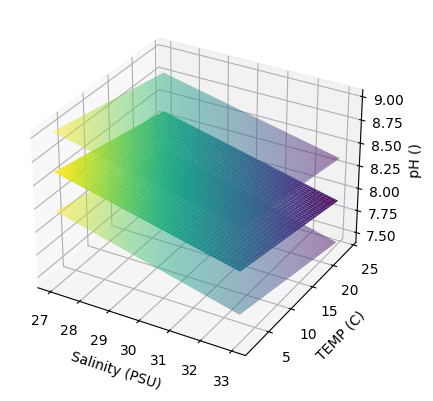

In [17]:
# Visualize the predictions with a mesh and the uncertainty as a second mesh
x1 = np.linspace(27, 33, 100)
x2 = np.linspace(1.622, 24, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)

Y_pred, Y_std = bayesian_regressor.predict(X, return_std=True)

Y_pred = Y_pred.reshape(100, 100)
Y_std = Y_std.reshape(100, 100)

# Add and subtract 2 standard deviations to the predictions
Y_plus_2_std = Y_pred + 2 * Y_std
Y_minus_2_std = Y_pred - 2 * Y_std

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1, X2, Y_pred, cmap='viridis', edgecolor='none')

ax.plot_surface(X1, X2, Y_plus_2_std, cmap='viridis', edgecolor='none', alpha=0.5)

ax.plot_surface(X1, X2, Y_minus_2_std, cmap='viridis', edgecolor='none',  alpha=0.5)

ax.set_xlabel('Salinity (PSU)')

ax.set_ylabel('TEMP (C)')
ax.set_zlabel('pH ()')
plt.show()